<a href="https://colab.research.google.com/github/fmejias/CS534-ArtificialIntelligenceProject/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS 534 - Artificial Intelligence**

## **Project Title: Predicting Student Intention to Dropout Through Tweets.**

### **Students**


*   Merzia Adamjee
*   Alketa Guxha
*   Felipe Mejias
*   Nikita Boguslavskii




# **Project Configuration**

## **Initial configuration of the environment for the development of the project**

In [1]:
from google.colab import drive
from google.colab import files
import pandas as pd
import re
import numpy as np

from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## **Install Textblob and Imbalanced Learn**

In [ ]:
!pip install textblob
!pip install imbalanced-learn
!pip3 install flair

## **Install NLTK datasets and libraries**

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('movie_reviews')

## **Google Authentication to read CSV File from Google Drive**

In [2]:
# Needed for Google Authentication Step
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Upload Dataset from Google Drive**

In [3]:
DATASET1_PATH = "/content/drive/My Drive/AI_Project_CS_534/Datasets/dropping_out_tweets_part1_labeled.csv"
DATASET2_PATH = "/content/drive/My Drive/AI_Project_CS_534/Datasets/dropping_out_tweets_part2_labeled.csv"
DATASET4_PATH = "/content/drive/My Drive/AI_Project_CS_534/Datasets/dropping_out_tweets_part4_labeled- DONE.csv"

dataset1_df = pd.read_csv(DATASET1_PATH, sep=";")

# Preprocess dataset2
dataset2_df = (pd.read_csv(DATASET2_PATH)).rename(columns={" tweet": "tweet", " label": "label"})
dataset2_df['label'] = dataset2_df['label'].str.replace(' Intention of dropout', 'Intention of dropout')
dataset2_df['label'] = dataset2_df['label'].str.replace(' Not intention of dropout', 'Not intention of dropout')

dataset4_df = pd.read_csv(DATASET4_PATH, sep=";")

## **Merge Datasets**

In [4]:
# Merge dataframes into single dataframe
frames = [dataset1_df, dataset2_df.iloc[0:2131], dataset4_df]
dataset_df = pd.concat(frames)

## **Dataset Information**

In [8]:
# Print a summary of the Dataset
result = dataset_df.head(10)
print("First 10 rows of the DataFrame:")
print(result)

First 10 rows of the DataFrame:
                    id  ...                     label
0  1309219160828895233  ...      Intention of dropout
1  1308809031583236096  ...  Not intention of dropout
2  1308716552229998593  ...  Not intention of dropout
3  1308483739584835585  ...  Not intention of dropout
4  1308351921875345409  ...  Not intention of dropout
5  1307763236062650368  ...  Not intention of dropout
6  1307001606450352128  ...  Not intention of dropout
7  1306800980307083267  ...  Not intention of dropout
8  1305869148463992832  ...  Not intention of dropout
9  1305659343971311616  ...  Not intention of dropout

[10 rows x 3 columns]


# **Dataset Preprocessing**

## **Select labeled dataset**

In [5]:
# NOTE: Select the data that is labeled
labeled_dataset_df = dataset_df

## **Check for imbalance classes**

Number of rows with intention of dropout:  3226
Number of rows with no intention of dropout:  5138


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


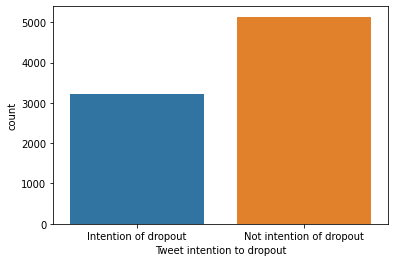

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Number of rows with intention of dropout: ", 
      len(labeled_dataset_df[(labeled_dataset_df['label'] == "Intention of dropout")]))
print("Number of rows with no intention of dropout: ", 
      len(labeled_dataset_df[(labeled_dataset_df['label'] == "Not intention of dropout")]))

sns.countplot(labeled_dataset_df.label)
plt.xlabel('Tweet intention to dropout');

## **Convert label to numerical value**

In [7]:
# Print categories
print("Categories: ", labeled_dataset_df["label"].astype('category').cat.categories)

# Convert label categorical value to numerical value
label_numerical_value = labeled_dataset_df["label"].astype('category').cat.codes
labeled_dataset_df["label"] = label_numerical_value

Categories:  Index(['Intention of dropout', 'Not intention of dropout'], dtype='object')


## **Filtering irrelevant examples**

In [8]:
IRRELEVANT_KEYWORDS = ["Bernie", "Trump", "Sanders", "to become", 
                       "to pursue", "and becoming", "and going",
                       "and be", "so I can", "so i can", "to run",
                       "to spend", "to focus", "and living", "marry",
                       "stripper", "and joining", "and pursuing",
                       "bts", "BTS", "and running", "to go", "and making",
                       "to dedicate"]

def filtering_irrelevant_examples(twitter_dataset):
  """
  Filtering irrelevant tweets from the Twitter dataset.
  """
  def check_tweet_relevance(tweet):
    """
    Filtering irrelevant tweets from the Twitter dataset.
    """
    if any(indicator in tweet for indicator in IRRELEVANT_KEYWORDS):
      return "irrelevant"
    return "relevant"
  return twitter_dataset[twitter_dataset["tweet"].apply(check_tweet_relevance) \
                         != "irrelevant"]

# Filter the irrelevant tweets
labeled_dataset_df = filtering_irrelevant_examples(labeled_dataset_df)
rows, columns = labeled_dataset_df.shape
print("New number of rows: ", rows)

New number of rows:  7153


## **Convert all letters to lower case**

In [9]:
def convert_letters_to_lower_case(twitter_dataset):
  """
  Convert all letters to lower case.
  """
  def tweet_to_lower_case(tweet):
    """
    Convert tweet text to lower case.
    """
    return tweet.lower()

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(tweet_to_lower_case)

# Convert all tweets to lower case
convert_letters_to_lower_case(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after lower case:")
print(result)

First 10 rows of the DataFrame after lower case:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## **Remove usernames that appear within a tweet**

In [10]:
def remove_usernames_from_tweets(twitter_dataset):
  """
  Remove all usernames that appear on a tweet.
  """
  def remove_username(tweet):
    """
    Remove username from tweet.
    """
    return re.sub('@[\w]+','', tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_username)

# Remove all usernames that appear in a tweet
remove_usernames_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## **Remove hashtags that appear within a tweet**

In [11]:
def remove_hashtags_from_tweets(twitter_dataset):
  """
  Remove all hashtags that appear on a tweet.
  """
  def remove_hashtags(tweet):
    """
    Remove hashtags from tweet.
    """
    return tweet.replace("#", "").replace("_", " ")

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_hashtags)

# Remove all hashtags that appear in a tweet
remove_hashtags_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## **Remove special characters and punctuation that appear within a tweet**

In [12]:
def remove_special_characters_and_punctuation_from_tweets(twitter_dataset):
  """
  Remove all special characters and punctuation that appear on a tweet.
  """
  def remove_special_characters_and_punctuation(tweet):
    """
    Remove special characters and punctuation from tweet.
    """
    return re.sub('[^A-Za-z0-9 ]+', '', tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_special_characters_and_punctuation)

# Remove all special characters and punctuation that appear in a tweet
remove_special_characters_and_punctuation_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## **Remove URLs that appear within a tweet**

In [13]:
def remove_urls_from_tweets(twitter_dataset):
  """
  Remove all urls that appear on a tweet.
  """
  def remove_urls(tweet):
    """
    Remove urls from tweet.
    """
    return re.sub(r'http\S+', '', tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_urls)

# Remove all urls that appear in a tweet
remove_urls_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## **Remove stop words that appear within a tweet**

In [14]:
from gensim.parsing.preprocessing import remove_stopwords

def remove_stop_words_from_tweets(twitter_dataset):
  """
  Remove all stop_words that appear on a tweet.
  """
  def remove_stop_words(tweet):
    """
    Remove stop_words from tweet.
    """
    return remove_stopwords(tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_stop_words)

# Remove all stop_words that appear in a tweet
remove_stop_words_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## **Remove short words that appear within a tweet**

In [15]:
def remove_short_words_from_tweets(twitter_dataset):
  """
  Remove all short words that appear on a tweet.
  """
  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(lambda tweet: ' '.join([word for word in tweet.split() if len(word) > 3]))

# Remove all short_words that appear in a tweet
remove_short_words_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# **Feature Extraction using Sentiment Analysis**

## **Build custom Textblob classifier**

In [405]:
from textblob import TextBlob 
from textblob.classifiers import NaiveBayesClassifier 

dropout_common_phrases_to_train = [ 
     ('I am considering dropping out.', 'neg'), 
     ('I want to dropout', 'neg'),
     ('make me contemplate dropping out of school', 'neg'),
     ('Im about to dropout', 'neg'), 
     ('I want to dropout', 'neg'), 
     ('I might have to dropout', 'neg'), 
     ("I am thinking on dropping out", 'neg'), 
     ("I need to dropout", "neg"),
     ("I just want to dropout", 'neg'), 
     ("I just wanna dropout", "neg"),
     ("I am ready to dropout", 'neg'), 
     ("I am going to dropout", "neg"),
     ("I have to dropout", 'neg'), 
     ("I have never wanted to", "neg")
]

textblob_classifier = NaiveBayesClassifier(dropout_common_phrases_to_train) 
textblob_analyzer = NaiveBayesAnalyzer()

## **Create features using sentiment analysis and unigrams and Textblob**

In [406]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

def calculate_features_using_polarity(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    tweet_sentiment = TextBlob(tweet, analyzer = textblob_analyzer)
    return tweet_sentiment.sentiment.p_pos
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    tweet_sentiment = TextBlob(tweet, analyzer = textblob_analyzer)
    return tweet_sentiment.sentiment.p_neg

  def calculate_sentiment_tweet_classification(tweet):
    """
    Classify the tweet in positive sentiment or negative sentiment.
    Set 1 to positive sentiment and -1 to negative sentiment
    """
    tweet_sentiment = TextBlob(tweet, classifier = textblob_classifier) 
    sentiment_classification = tweet_sentiment.classify()
    return 1 if sentiment_classification == 'pos' else -1
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  twitter_dataset["unigram_textblob_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["unigram_textblob_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["unigram_textblob_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["unigram_textblob_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["unigram_textblob_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["unigram_textblob_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)
  twitter_dataset["unigram_textblob_sentiment_classification"] = twitter_dataset["tweet"].apply(calculate_sentiment_tweet_classification)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

First 10 rows of the DataFrame after removing usernames:
                     id  ... unigram_textblob_sentiment_classification
0   1309219160828895233  ...                                        -1
1   1308809031583236096  ...                                        -1
2   1308716552229998593  ...                                        -1
3   1308483739584835585  ...                                        -1
4   1308351921875345409  ...                                        -1
5   1307763236062650368  ...                                        -1
7   1306800980307083267  ...                                        -1
8   1305869148463992832  ...                                        -1
9   1305659343971311616  ...                                        -1
10  1305617685020053512  ...                                        -1

[10 rows x 10 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## **Create features using sentiment analysis and bigrams and Textblob**

In [407]:
from textblob import TextBlob

def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_bigram_features_using_polarity(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity > 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity >= 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["bigram_textblob_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["bigram_textblob_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["bigram_textblob_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["bigram_textblob_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["bigram_textblob_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["bigram_textblob_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_bigram_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

First 10 rows of the DataFrame after removing usernames:
                     id  ... bigram_textblob_negative_score
0   1309219160828895233  ...                           -0.8
1   1308809031583236096  ...                            0.0
2   1308716552229998593  ...                           -0.6
3   1308483739584835585  ...                            0.0
4   1308351921875345409  ...                           -0.5
5   1307763236062650368  ...                            0.0
7   1306800980307083267  ...                            0.0
8   1305869148463992832  ...                            0.0
9   1305659343971311616  ...                            0.0
10  1305617685020053512  ...                            0.0

[10 rows x 16 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## **Create features using sentiment analysis and trigrams and Textblob**

In [408]:
from textblob import TextBlob

def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_trigrams_features_using_polarity(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity > 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity >= 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["trigrams_textblob_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["trigrams_textblob_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["trigrams_textblob_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["trigrams_textblob_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["trigrams_textblob_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["trigrams_textblob_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_trigrams_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

First 10 rows of the DataFrame after removing usernames:
                     id  ... trigrams_textblob_negative_score
0   1309219160828895233  ...                            -1.20
1   1308809031583236096  ...                             0.00
2   1308716552229998593  ...                            -0.67
3   1308483739584835585  ...                             0.00
4   1308351921875345409  ...                            -0.75
5   1307763236062650368  ...                             0.00
7   1306800980307083267  ...                             0.00
8   1305869148463992832  ...                             0.00
9   1305659343971311616  ...                             0.00
10  1305617685020053512  ...                             0.00

[10 rows x 22 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## **Create features using sentiment analysis and unigrams and Vader**

In [409]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sentiment_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [410]:
def calculate_features_using_polarity_vader(twitter_dataset):
  """
  Use Vader polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  twitter_dataset["unigram_vader_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["unigram_vader_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["unigram_vader_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["unigram_vader_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity_vader(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

First 10 rows of the DataFrame after removing usernames:
                     id  ... unigram_vader_ratio_negative_words
0   1309219160828895233  ...                           0.142857
1   1308809031583236096  ...                           0.050000
2   1308716552229998593  ...                           0.181818
3   1308483739584835585  ...                           0.142857
4   1308351921875345409  ...                           0.100000
5   1307763236062650368  ...                           0.050000
7   1306800980307083267  ...                           0.000000
8   1305869148463992832  ...                           0.058824
9   1305659343971311616  ...                           0.000000
10  1305617685020053512  ...                           0.076923

[10 rows x 26 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## **Create features using sentiment analysis and bigrams and Vader**

In [411]:
def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_bigram_vader_features_using_polarity(twitter_dataset):
  """
  Use Vader polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] > 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] >= 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["bigram_vader_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["bigram_vader_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["bigram_vader_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["bigram_vader_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["bigram_vader_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["bigram_vader_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_bigram_vader_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

First 10 rows of the DataFrame after removing usernames:
                     id  ... bigram_vader_negative_score
0   1309219160828895233  ...                     -0.9102
1   1308809031583236096  ...                     -0.8038
2   1308716552229998593  ...                     -2.8257
3   1308483739584835585  ...                     -0.3818
4   1308351921875345409  ...                     -0.2732
5   1307763236062650368  ...                     -0.5464
7   1306800980307083267  ...                      0.0000
8   1305869148463992832  ...                     -0.3062
9   1305659343971311616  ...                      0.0000
10  1305617685020053512  ...                     -1.3130

[10 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## **Create features using sentiment analysis and trigrams and Vader**

In [412]:
def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_trigrams_vader_features_using_polarity(twitter_dataset):
  """
  Use Vader polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] > 0:
        number_of_positive_trigrams = number_of_positive_trigrams + 1
    return number_of_positive_trigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] >= 0:
        number_of_positive_trigrams = number_of_positive_trigrams + 1
    return number_of_positive_trigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_trigrams = number_of_negative_trigrams + 1
    return number_of_negative_trigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_trigrams = number_of_negative_trigrams + 1
    return number_of_negative_trigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["trigrams_vader_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["trigrams_vader_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["trigrams_vader_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["trigrams_vader_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["trigrams_vader_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["trigrams_vader_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_trigrams_vader_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

First 10 rows of the DataFrame after removing usernames:
                     id  ... trigrams_vader_negative_score
0   1309219160828895233  ...                       -1.2062
1   1308809031583236096  ...                       -1.2057
2   1308716552229998593  ...                       -4.1414
3   1308483739584835585  ...                        0.0000
4   1308351921875345409  ...                       -0.2023
5   1307763236062650368  ...                       -0.8196
7   1306800980307083267  ...                        0.0000
8   1305869148463992832  ...                       -0.4593
9   1305659343971311616  ...                        0.0000
10  1305617685020053512  ...                       -1.9868

[10 rows x 38 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## **Create features using sentiment analysis and trigrams and Flair**

In [ ]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [ ]:
def calculate_features_using_polarity_flair(twitter_dataset):
  """
  Use flair polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words
  
  def calculate_positive_words_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    positive_words_score = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score > 0:
        positive_words_score = positive_words_score + s.labels[0].score
    return positive_words_score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words
  
  def calculate_negative_words_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    negative_words_score = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score < 0:
        negative_words_score = negative_words_score + s.labels[0].score
    return negative_words_score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  twitter_dataset["unigram_flair_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["unigram_flair_positive_words_score"] = twitter_dataset["tweet"].apply(calculate_positive_words_score)
  twitter_dataset["unigram_flair_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["unigram_flair_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["unigram_flair_negative_words_score"] = twitter_dataset["tweet"].apply(calculate_negative_words_score)
  twitter_dataset["unigram_flair_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity_flair(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

## **Download Pandas Dataframe that contains all the extracted features**

In [ ]:
from google.colab import files
labeled_dataset_df.to_csv('dropping_out_tweets_part1_labeled_with_features.csv')
files.download('dropping_out_tweets_part1_labeled_with_features.csv')

 ## **Add Polarity Score of the entire tweet as a feature**

In [413]:
from textblob import TextBlob

def calculate_features_using_polarity_score(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_textblob_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    return TextBlob(tweet).polarity
  
  def calculate_vader_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    return sentiment_analyzer.polarity_scores(tweet)["compound"]
  
  def calculate_flair_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    s = flair.data.Sentence(tweet)
    flair_sentiment.predict(s)
    return s.labels[0].score if len(s.labels) > 0 else 0
  
  twitter_dataset["unigram_textblob_score"] = twitter_dataset["tweet"].apply(calculate_textblob_score)
  twitter_dataset["unigram_vader_score"] = twitter_dataset["tweet"].apply(calculate_vader_score)
  #twitter_dataset["unigram_flair_score"] = twitter_dataset["tweet"].apply(calculate_flair_score)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity_score(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


First 10 rows of the DataFrame after removing usernames:
                     id  ... unigram_vader_score
0   1309219160828895233  ...             -0.5423
1   1308809031583236096  ...             -0.0516
2   1308716552229998593  ...             -0.8689
3   1308483739584835585  ...              0.0258
4   1308351921875345409  ...             -0.2023
5   1307763236062650368  ...             -0.2732
7   1306800980307083267  ...              0.0000
8   1305869148463992832  ...             -0.1531
9   1305659343971311616  ...              0.2500
10  1305617685020053512  ...             -0.6738

[10 rows x 40 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## **Download Pandas Dataframe that contains all the extracted features**

In [ ]:
from google.colab import files
labeled_dataset_df.to_csv('dropping_out_tweets_part1_labeled_with_features.csv')
files.download('dropping_out_tweets_part1_labeled_with_features.csv')

## **Create dictionary that contains all the names of the extracted features**

In [414]:
SENTIMENT_ANALYSIS_FEATURES_DICT = {
    "textblob_unigram_features" : ["unigram_textblob_number_positive_words",
                                   "unigram_textblob_ratio_positive_words",
                                   "unigram_textblob_number_negative_words",
                                   "unigram_textblob_ratio_negative_words",
                                   "unigram_textblob_positive_score",
                                   "unigram_textblob_negative_score",
                                   "unigram_textblob_score"],
    "textblob_bigram_features" : ["bigram_textblob_ratio_positive_words",
                                  "bigram_textblob_number_negative_words",
                                  "bigram_textblob_ratio_negative_words",
                                  "bigram_textblob_positive_score",
                                  "bigram_textblob_negative_score"],
    "textblob_trigram_features" : ["trigrams_textblob_ratio_positive_words",
                                   "trigrams_textblob_number_negative_words",
                                   "trigrams_textblob_ratio_negative_words",
                                   "trigrams_textblob_positive_score",
                                   "trigrams_textblob_negative_score"],  
    "vader_unigram_features" : ["unigram_vader_positive_words", 
                                "unigram_vader_ratio_positive_words", 
                                "unigram_vader_negative_words", 
                                "unigram_vader_ratio_negative_words",
                                "unigram_vader_score"],
    "vader_bigram_features" : ["bigram_vader_number_positive_words", 
                               "bigram_vader_ratio_positive_words", 
                               "bigram_vader_number_negative_words", 
                               "bigram_vader_ratio_negative_words",
                               "bigram_vader_positive_score",
                               "bigram_vader_negative_score"],
    "vader_trigram_features" : ["trigrams_vader_number_positive_words", 
                                "trigrams_vader_ratio_positive_words", 
                                "trigrams_vader_number_negative_words", 
                                "trigrams_vader_ratio_negative_words",
                                "trigrams_vader_positive_score",
                                "trigrams_vader_negative_score"],
    "flair_unigram_features" : ["unigram_flair_positive_words",
                                "unigram_flair_positive_words_score",
                                "unigram_flair_ratio_positive_words",
                                "unigram_flair_score"]                                                                      
}

# **Feature Extraction using Bag of Words, TF-IDF and Word2Vec**

## **Tweets preprocessing before Feature Extraction**

### **Tokenization of all the tweets before normalization**

In [514]:
tokenized_tweet_df = labeled_dataset_df.tweet.apply(lambda tweet: tweet.split())
tokenized_tweet_df.head()

0    [lost, jobs, pandemic, jobs, august, budget, c...
1    [curveball, spector, work, area, pandemic, cli...
2    [socioeconomic, fallout, pandemic, billions, c...
3    [imagine, dropping, school, host, parties, pan...
4    [drop, school, challenge, naming, past, school...
Name: tweet, dtype: object

### **Normalization of the tokenized tweets**

In [515]:
from nltk.stem.porter import * 

stemmer = PorterStemmer() 
tokenized_tweet_df = tokenized_tweet_df.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet_df.head()

0    [lost, job, pandem, job, august, budget, cut, ...
1    [curvebal, spector, work, area, pandem, client...
2    [socioeconom, fallout, pandem, billion, childr...
3    [imagin, drop, school, host, parti, pandem, em...
4    [drop, school, challeng, name, past, school, d...
Name: tweet, dtype: object

### **Stitch tokens back together into tweets**

In [516]:
for i in range(len(tokenized_tweet_df)):
    tokenized_tweet_df.iloc[i] = ' '.join(tokenized_tweet_df.iloc[i])    
labeled_dataset_df['tweet'] = tokenized_tweet_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## **Bag of words features**

In [517]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, 
                                 stop_words='english')
bow = bow_vectorizer.fit_transform(labeled_dataset_df['tweet'])
bow.shape

(7153, 1000)

## **TD-IDF features**

In [518]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, 
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(labeled_dataset_df['tweet'])
tfidf.shape

(7153, 1000)

## **Word2Vec features**

### **Train the Word2Vec model**

In [519]:
tokenized_tweet = labeled_dataset_df['tweet'].apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200,
            window=5,
            min_count=2,                                 
            sg = 1,
            hs = 0,
            negative = 10,
            workers= 32,
            seed = 34
) 

model_w2v.train(tokenized_tweet, 
                total_examples = len(labeled_dataset_df['tweet']), 
                epochs=20)

(1263350, 1773940)

### **Create a vector for each tweet**

In [520]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

### **Preparing Word2Vec features set**

In [521]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet.iloc[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(7153, 200)

# **Tweets Statistics**

## **Create WordCloud of most used sentiment words in all the tweets**

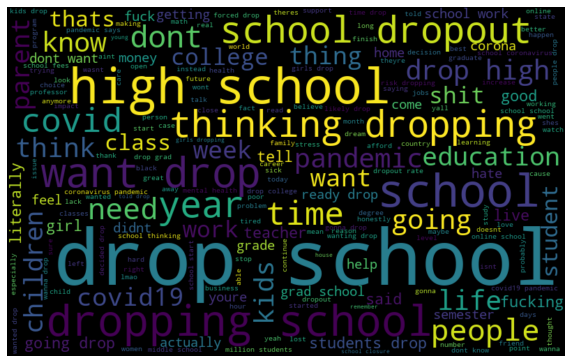

In [415]:
all_words = ' '.join([tweet for tweet in labeled_dataset_df['tweet']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, 
                      max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

## **Create WordCloud of most used sentiment words in all the tweets with intention to dropout**

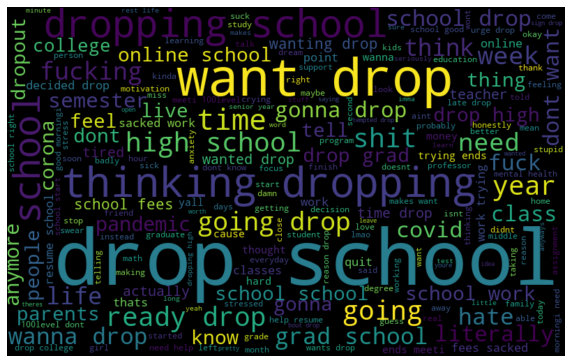

In [416]:
positive_words = ' '.join([tweet for tweet in labeled_dataset_df['tweet'][labeled_dataset_df['label'] == 0]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, 
                      max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Create WordCloud of most used sentiment words in all the tweets with no intention to dropout**

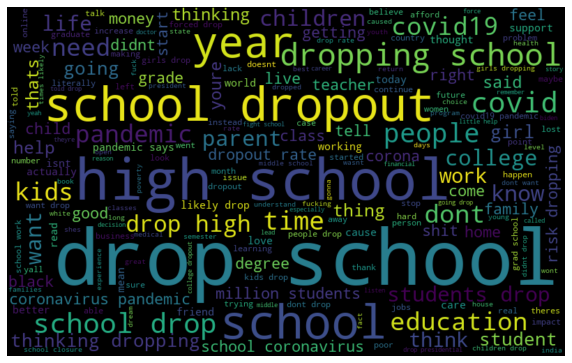

In [417]:
negative_words = ' '.join([tweet for tweet in labeled_dataset_df['tweet'][labeled_dataset_df['label'] == 1]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, 
                      max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Create Plot with most frequent positive words in all the tweets**

Text(0.5, 1.0, 'Most frequent positive words')

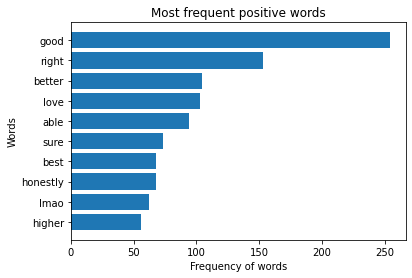

In [418]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import operator

def calculate_most_frequently_n_positive_words(twitter_dataset, number_of_words):
  """
  Use Textblob polarity to calculate the most frequently positive words.
  """
  def calculate_most_frequently_positive_words(tweet_column):
    """
    Count number of positive words in a tweet.
    """
    positive_words_dict = dict()
    tweets_list = tweet_column.values
    for tweet in tweets_list:
      for word in tweet.split():
        if TextBlob(word).polarity > 0.2:
          if word in positive_words_dict:
            positive_words_dict[word] = positive_words_dict[word] + 1
          else:
            positive_words_dict[word] = 1

    return dict(sorted(positive_words_dict.items(), key = operator.itemgetter(1), 
                       reverse = True)[:number_of_words])
  
  return calculate_most_frequently_positive_words(twitter_dataset["tweet"])


# Calculate most frequently positive words
frequent_positive_words_dict = calculate_most_frequently_n_positive_words(labeled_dataset_df,  
                                                                          number_of_words = 10)

# Plot the most frequent positive words in a bar chart
fig, ax = plt.subplots()
ax.barh(*zip(*frequent_positive_words_dict.items()))
ax.invert_yaxis()
ax.set_xlabel('Frequency of words')
ax.set_ylabel('Words')
ax.set_title('Most frequent positive words')

## **Create Plot with most frequent negative words in all the tweets**

Text(0.5, 1.0, 'Most frequent negative words')

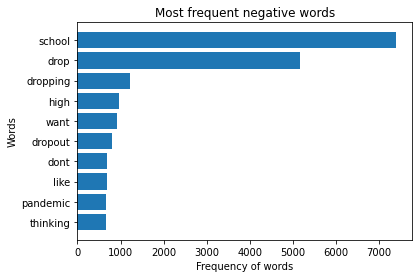

In [419]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import operator

def calculate_most_frequently_n_negative_words(twitter_dataset, number_of_words):
  """
  Use Textblob polarity to calculate the most frequently negative words.
  """
  def calculate_most_frequently_negative_words(tweet_column):
    """
    Count number of negative words in a tweet.
    """
    negative_words_dict = dict()
    tweets_list = tweet_column.values
    for tweet in tweets_list:
      for word in tweet.split():
        if TextBlob(word).polarity < 0.2:
          if word in negative_words_dict:
            negative_words_dict[word] = negative_words_dict[word] + 1
          else:
            negative_words_dict[word] = 1

    return dict(sorted(negative_words_dict.items(), key = operator.itemgetter(1), 
                       reverse = True)[:number_of_words])
  
  return calculate_most_frequently_negative_words(twitter_dataset["tweet"])


# Calculate most frequently negative words
frequent_negative_words_dict = calculate_most_frequently_n_negative_words(labeled_dataset_df,  
                                                                          number_of_words = 10)

# Plot the most frequent negative words in a bar chart
fig, ax = plt.subplots()
ax.barh(*zip(*frequent_negative_words_dict.items()))
ax.invert_yaxis()
ax.set_xlabel('Frequency of words')
ax.set_ylabel('Words')
ax.set_title('Most frequent negative words')

# **Model training using Sentiment Analysis Features**

## **Training the models using only the Textblob Features**

### **Select the Textblob Features**

In [420]:
# Select calculated Textblob features
textblob_features_list = SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_unigram_features"] + \
                         SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_bigram_features"]  + \
                         SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_trigram_features"]

# Select the Texblob features from the Dataset
dataset_sentiment_features = labeled_dataset_df[textblob_features_list]

### **Normalize calculated features using Scaler**

In [194]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Normalize using the mean value
sc = StandardScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Normalize calculated features using MinMaxScaler**

In [421]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Select X and Y**

In [422]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return dataset_sentiment_features, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

### **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

### **Select train and test data**

In [424]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

### **Logistic Regression Model**

In [425]:
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(random_state = 0).fit(X_train,
                                                               Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6915914221218962
Training Precision:  0.7181528662420382
Training Recall:  0.6341394825646794
Training F-measure:  0.673536439665472

Test Accuracy:  0.7020316027088036
Test Precision:  0.7270341207349081
Test Recall:  0.6338672768878718
Test F-measure:  0.6772616136919315


### **Naive Bayes Model**

In [426]:
from sklearn.naive_bayes import GaussianNB

# Train the model
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6695823927765236
Training Precision:  0.7077344284736482
Training Recall:  0.5815523059617548
Training F-measure:  0.6384686631676444

Test Accuracy:  0.672686230248307
Test Precision:  0.7024793388429752
Test Recall:  0.5835240274599542
Test F-measure:  0.6375000000000001


### **Multinomial Naive Bayes Model**

In [427]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6413656884875847
Training Precision:  0.6587351283656857
Training Recall:  0.5916760404949382
Training F-measure:  0.6234074074074074

Test Accuracy:  0.6455981941309256
Test Precision:  0.6572890025575447
Test Recall:  0.5881006864988558
Test F-measure:  0.6207729468599034


### **SVM Model**

In [428]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6908860045146726
Training Precision:  0.7238438832404067
Training Recall:  0.6206411698537683
Training F-measure:  0.6682816048448145

Test Accuracy:  0.6975169300225733
Test Precision:  0.7241379310344828
Test Recall:  0.6247139588100686
Test F-measure:  0.6707616707616708


### **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [200]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
random_grid = {'n_estimators': n_estimators,
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

#### **Find the parameters that optimize the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = random_grid, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [203]:
# Select best Random Forest Model
best_random_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = best_random_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = best_random_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.991074748977315
Training Precision:  0.9984962406015038
Training Recall:  0.9837037037037037
Training F-measure:  0.9910447761194031

Test Accuracy:  0.7488855869242199
Test Precision:  0.7425149700598802
Test Recall:  0.7492447129909365
Test F-measure:  0.7458646616541352


### **Stacking Model**

In [429]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', RandomForestClassifier()))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9544300225733634
Training Precision:  0.9570257280180944
Training Recall:  0.9519122609673791
Training F-measure:  0.9544621457775272

Test Accuracy:  0.7658013544018059
Test Precision:  0.7564245810055866
Test Recall:  0.7745995423340961
Test F-measure:  0.7654041831543243


## **Training the models using only the Vader Features**

### **Select the Vader Features**

In [491]:
# Select calculated Vader features
vader_features_list = SENTIMENT_ANALYSIS_FEATURES_DICT["vader_unigram_features"] + \
                      SENTIMENT_ANALYSIS_FEATURES_DICT["vader_bigram_features"]  + \
                      SENTIMENT_ANALYSIS_FEATURES_DICT["vader_trigram_features"]

# Select the Vader features from the Dataset
dataset_sentiment_features = labeled_dataset_df[vader_features_list]

### **Normalize calculated features using Scaler**

In [481]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Normalize using the mean value
sc = StandardScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Normalize calculated features using MinMaxScaler**

In [492]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Select X and Y**

In [493]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return dataset_sentiment_features, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

### **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

### **Select train and test data**

In [495]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

### **Logistic Regression Model**

In [496]:
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression().fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7227708803611738
Training Precision:  0.6977611940298507
Training Recall:  0.7890295358649789
Training F-measure:  0.7405940594059407

Test Accuracy:  0.6963882618510158
Test Precision:  0.6660098522167488
Test Recall:  0.7725714285714286
Test F-measure:  0.7153439153439155


### **Naive Bayes Model**

In [497]:
from sklearn.naive_bayes import GaussianNB

# Train the model
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6845372460496614
Training Precision:  0.6954074074074074
Training Recall:  0.660196905766526
Training F-measure:  0.6773448773448772

Test Accuracy:  0.6805869074492099
Test Precision:  0.6811254396248535
Test Recall:  0.664
Test F-measure:  0.6724537037037037


### **Multinomial Naive Bayes Model**

In [498]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.644892776523702
Training Precision:  0.6330087134802665
Training Recall:  0.6947960618846695
Training F-measure:  0.6624647981762103

Test Accuracy:  0.623589164785553
Test Precision:  0.6025641025641025
Test Recall:  0.6982857142857143
Test F-measure:  0.6469031233456856


### **SVM Model**

In [499]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.731941309255079
Training Precision:  0.7334273624823695
Training Recall:  0.7313642756680732
Training F-measure:  0.7323943661971831

Test Accuracy:  0.7240406320541761
Test Precision:  0.7183257918552036
Test Recall:  0.7257142857142858
Test F-measure:  0.7220011370096646


### **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
random_grid = {'n_estimators': n_estimators,
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

#### **Find the parameters that optimize the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = random_grid, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
best_random_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = best_random_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = best_random_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.991074748977315
Training Precision:  0.9984962406015038
Training Recall:  0.9837037037037037
Training F-measure:  0.9910447761194031

Test Accuracy:  0.7488855869242199
Test Precision:  0.7425149700598802
Test Recall:  0.7492447129909365
Test F-measure:  0.7458646616541352


### **Stacking Model**

In [500]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', RandomForestClassifier()))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9257900677200903
Training Precision:  0.9618786215309546
Training Recall:  0.8872011251758087
Training F-measure:  0.923031899326895

Test Accuracy:  0.7646726862302483
Test Precision:  0.7675233644859814
Test Recall:  0.7508571428571429
Test F-measure:  0.7590987868284229


## **Training the models using Vader and Textblob Features**

### **Select the Vader Features**

In [508]:
# Select calculated Vader and Textblob features
textblob_features_list = SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_unigram_features"] + \
                         SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_bigram_features"]  + \
                         SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_trigram_features"]

vader_features_list = SENTIMENT_ANALYSIS_FEATURES_DICT["vader_unigram_features"] + \
                      SENTIMENT_ANALYSIS_FEATURES_DICT["vader_bigram_features"]  + \
                      SENTIMENT_ANALYSIS_FEATURES_DICT["vader_trigram_features"]

# Select the Vader features from the Dataset
dataset_sentiment_features = labeled_dataset_df[vader_features_list + textblob_features_list]

### **Normalize calculated features using Scaler**

In [461]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Normalize using the mean value
sc = StandardScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Normalize calculated features using MinMaxScaler**

In [509]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Select X and Y**

In [510]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return dataset_sentiment_features, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

### **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

### **Select train and test data**

In [512]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

### **Logistic Regression Model**

In [ ]:
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(random_state = 0).fit(X_train,
                                                               Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

### **Naive Bayes Model**

In [476]:
from sklearn.naive_bayes import GaussianNB

# Train the model
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6994920993227991
Training Precision:  0.7121861604409063
Training Recall:  0.661547212741752
Training F-measure:  0.6859333529932173

Test Accuracy:  0.7065462753950339
Test Precision:  0.7301401869158879
Test Recall:  0.6838074398249453
Test F-measure:  0.7062146892655367


### **Multinomial Naive Bayes Model**

In [477]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6505361173814899
Training Precision:  0.6441854010546767
Training Recall:  0.6601251422070534
Training F-measure:  0.6520578732968113

Test Accuracy:  0.6534988713318285
Test Precision:  0.6626898047722343
Test Recall:  0.6684901531728665
Test F-measure:  0.6655773420479303


### **SVM Model**

In [478]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7415349887133182
Training Precision:  0.7581238503985285
Training Recall:  0.7033560864618885
Training F-measure:  0.7297137798760697

Test Accuracy:  0.7341986455981941
Test Precision:  0.7560693641618497
Test Recall:  0.7155361050328227
Test F-measure:  0.7352445193929174


### **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
random_grid = {'n_estimators': n_estimators,
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

#### **Find the parameters that optimize the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = random_grid, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
best_random_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = best_random_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = best_random_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.991074748977315
Training Precision:  0.9984962406015038
Training Recall:  0.9837037037037037
Training F-measure:  0.9910447761194031

Test Accuracy:  0.7488855869242199
Test Precision:  0.7425149700598802
Test Recall:  0.7492447129909365
Test F-measure:  0.7458646616541352


### **Stacking Model**

In [479]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', RandomForestClassifier()))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9915349887133182
Training Precision:  0.9945621064682313
Training Recall:  0.9883390216154722
Training F-measure:  0.9914407988587731

Test Accuracy:  0.8086907449209932
Test Precision:  0.8142076502732241
Test Recall:  0.8150984682713348
Test F-measure:  0.8146528157463095


# **Model training using Word2Vec Features**

## **Normalize calculated features using MinMaxScaler**

In [536]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(wordvec_df)

### **Select X and Y**

In [537]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return wordvec_df, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

## **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

## **Select train and test data**

In [539]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

## **Logistic Regression Model**

In [540]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8308408577878104
Training Precision:  0.8431372549019608
Training Recall:  0.8169879854708019
Training F-measure:  0.8298566765999715

Test Accuracy:  0.8357787810383747
Test Precision:  0.8381642512077294
Test Recall:  0.8155111633372503
Test F-measure:  0.8266825491363906


### **Naive Bayes Model**

In [541]:
from sklearn.naive_bayes import GaussianNB

# Train the model
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7982505643340858
Training Precision:  0.843400447427293
Training Recall:  0.737356803576418
Training F-measure:  0.7868217054263565

Test Accuracy:  0.804176072234763
Test Precision:  0.8342175066312998
Test Recall:  0.7391304347826086
Test F-measure:  0.7838006230529595


### **SVM Model**

In [542]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.886568848758465
Training Precision:  0.9118432769367765
Training Recall:  0.8583403185247276
Training F-measure:  0.8842832469775476

Test Accuracy:  0.8623024830699775
Test Precision:  0.8770186335403727
Test Recall:  0.8296122209165687
Test F-measure:  0.8526570048309179


### **Multinomial Naive Bayes Model**

In [546]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8031884875846501
Training Precision:  0.8209876543209876
Training Recall:  0.7803855825649623
Training F-measure:  0.8001718951439623

Test Accuracy:  0.8058690744920993
Test Precision:  0.8080194410692588
Test Recall:  0.781433607520564
Test F-measure:  0.7945041816009558


### **Stacking Model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', RandomForestClassifier()))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

# **Model training using TF-IDF Features**

## **Normalize calculated features using MinMaxScaler**

In [548]:
# Feature Scaling
from sklearn.preprocessing import MaxAbsScaler

# Normalize using the mean value
sc = MaxAbsScaler()
normalized_df = sc.fit_transform(tfidf)

### **Select X and Y**

In [556]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return tfidf, labeled_dataset_df.label

X, Y = select_data(normalize_data = False)

## **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

## **Select train and test data**

In [558]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

## **Logistic Regression Model**

In [559]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.858352144469526
Training Precision:  0.857261871702305
Training Recall:  0.863013698630137
Training F-measure:  0.8601281694065199

Test Accuracy:  0.8357787810383747
Test Precision:  0.8171557562076749
Test Recall:  0.8487690504103166
Test F-measure:  0.8326624496837263


### **SVM Model**

In [561]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9521726862302483
Training Precision:  0.9654974123059229
Training Recall:  0.9387755102040817
Training F-measure:  0.9519489723600284

Test Accuracy:  0.8679458239277652
Test Precision:  0.8619883040935673
Test Recall:  0.8640093786635404
Test F-measure:  0.8629976580796253


### **Multinomial Naive Bayes Model**

In [562]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8429740406320542
Training Precision:  0.8818970861748295
Training Recall:  0.7953592395862454
Training F-measure:  0.8363957077759812

Test Accuracy:  0.827313769751693
Test Precision:  0.8414481897627965
Test Recall:  0.7901524032825322
Test F-measure:  0.814993954050786


### **Stacking Model**

In [563]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', RandomForestClassifier()))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9667042889390519
Training Precision:  0.979065098938916
Training Recall:  0.9544310875034946
Training F-measure:  0.9665911664779162

Test Accuracy:  0.871331828442438
Test Precision:  0.8706998813760379
Test Recall:  0.8604923798358733
Test F-measure:  0.865566037735849


# **Model training using Bag of Words Features**

## **Normalize calculated features using MinMaxScaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MaxAbsScaler

# Normalize using the mean value
sc = MaxAbsScaler()
normalized_df = sc.fit_transform(bow)

### **Select X and Y**

In [564]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return bow, labeled_dataset_df.label

X, Y = select_data(normalize_data = False)

## **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

## **Select train and test data**

In [566]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

## **Logistic Regression Model**

In [567]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8765519187358917
Training Precision:  0.9104615384615384
Training Recall:  0.8351679367767428
Training F-measure:  0.8711909318416016

Test Accuracy:  0.8436794582392777
Test Precision:  0.88510101010101
Test Recall:  0.790304396843292
Test F-measure:  0.8350208457415128


### **SVM Model**

In [568]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9235327313769752
Training Precision:  0.9540090771558245
Training Recall:  0.8899237933954276
Training F-measure:  0.9208528037383178

Test Accuracy:  0.8465011286681715
Test Precision:  0.8596491228070176
Test Recall:  0.8286358511837655
Test F-measure:  0.8438576349024111


### **Multinomial Naive Bayes Model**

In [569]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8366252821670429
Training Precision:  0.9188619599578504
Training Recall:  0.7383573243014394
Training F-measure:  0.8187793427230046

Test Accuracy:  0.8340857787810384
Test Precision:  0.906721536351166
Test Recall:  0.7452085682074409
Test F-measure:  0.8180693069306932


### **Stacking Model**

In [570]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', RandomForestClassifier()))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9382054176072234
Training Precision:  0.9522283716865715
Training Recall:  0.9226644086931979
Training F-measure:  0.9372133027522936

Test Accuracy:  0.8510158013544018
Test Precision:  0.8643274853801169
Test Recall:  0.8331454340473506
Test F-measure:  0.8484500574052812


# **Model training using BERT embeddings**

## **Install transformers library**

In [ ]:
!pip install transformers

## **Import necessary libraries**

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd
import torch
import transformers as ppb
import warnings

warnings.filterwarnings('ignore')

## **Load pretrained BERT model**

In [24]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, 
                                                    ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
bert_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

## **Select datasets to process**

In [32]:
bert_dataset1 = labeled_dataset_df.iloc[0:3200]
bert_dataset2 = labeled_dataset_df.iloc[3200:5000]
bert_dataset3 = labeled_dataset_df.iloc[5000:-1]

## **Tokenize tweets using BERT Tokenizer**

In [33]:
tokenized_tweets_dataset1 = bert_dataset1["tweet"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True)))
tokenized_tweets_dataset2 = bert_dataset2["tweet"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True)))
tokenized_tweets_dataset3 = bert_dataset3["tweet"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True)))

## **Padded tokenize tweets values**

In [34]:
max_len = 0
for i in tokenized_tweets_dataset1.values:
    if len(i) > max_len:
        max_len = len(i)

padded_tokenize_tweets_dataset1 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_tweets_dataset1.values])

max_len = 0
for i in tokenized_tweets_dataset2.values:
    if len(i) > max_len:
        max_len = len(i)

padded_tokenize_tweets_dataset2 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_tweets_dataset2.values])

max_len = 0
for i in tokenized_tweets_dataset3.values:
    if len(i) > max_len:
        max_len = len(i)

padded_tokenize_tweets_dataset3 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_tweets_dataset3.values])

## **Add the attention mask**

In [35]:
attention_mask_dataset1 = np.where(padded_tokenize_tweets_dataset1 != 0, 1, 0)
attention_mask_dataset2 = np.where(padded_tokenize_tweets_dataset2 != 0, 1, 0)
attention_mask_dataset3 = np.where(padded_tokenize_tweets_dataset3 != 0, 1, 0)

## **Calculate the BERT Features for dataset 1**

In [36]:
input_tweets_ids_dataset1 = torch.tensor(padded_tokenize_tweets_dataset1)  
attention_mask_dataset1 = torch.tensor(attention_mask_dataset1)

with torch.no_grad():
    last_hidden_states_dataset1 = bert_model(input_tweets_ids_dataset1, 
                                             attention_mask = attention_mask_dataset1)

## **Calculate the BERT Features for dataset 2**

In [37]:
input_tweets_ids_dataset2 = torch.tensor(padded_tokenize_tweets_dataset2)  
attention_mask_dataset2 = torch.tensor(attention_mask_dataset2)

with torch.no_grad():
    last_hidden_states_dataset2 = bert_model(input_tweets_ids_dataset2, 
                                             attention_mask = attention_mask_dataset2)

## **Calculate the BERT Features for dataset 3**

In [38]:
input_tweets_ids_dataset3 = torch.tensor(padded_tokenize_tweets_dataset3)  
attention_mask_dataset3 = torch.tensor(attention_mask_dataset3)

with torch.no_grad():
    last_hidden_states_dataset3 = bert_model(input_tweets_ids_dataset3, 
                                             attention_mask = attention_mask_dataset3)

## **Select the BERT features**

In [39]:
features_dataset1 = last_hidden_states_dataset1[0][:,0,:].numpy()
features_dataset2 = last_hidden_states_dataset2[0][:,0,:].numpy()
features_dataset3 = last_hidden_states_dataset3[0][:,0,:].numpy()

features = np.concatenate((features_dataset1, features_dataset2, 
                           features_dataset3), axis=0)

## **Normalize calculated features using MinMaxScaler**

In [51]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(features)

## **Select X and Y**

In [52]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return features, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

## **Handle imbalance data using SMOTE**

In [53]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y.iloc[0:7152])

## **Select train and test data**

In [54]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

## **Logistic Regression Model**

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8591589048828676
Training Precision:  0.8803317535545023
Training Recall:  0.833426808749299
Training F-measure:  0.8562373955632384

Test Accuracy:  0.8211060948081265
Test Precision:  0.8297101449275363
Test Recall:  0.7960602549246814
Test F-measure:  0.8125369603784742


### **Naive Bayes Model**

In [56]:
from sklearn.naive_bayes import GaussianNB

# Train the model
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7585379621789444
Training Precision:  0.7638691322901849
Training Recall:  0.7529444756029164
Training F-measure:  0.7583674622228499

Test Accuracy:  0.7533860045146726
Test Precision:  0.7431506849315068
Test Recall:  0.7543453070683661
Test F-measure:  0.748706152961472


### **SVM Model**

In [57]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9098221845893311
Training Precision:  0.9404152873909118
Training Recall:  0.8763320246775098
Training F-measure:  0.9072434315575555

Test Accuracy:  0.8521444695259593
Test Precision:  0.8678090575275398
Test Recall:  0.8215527230590962
Test F-measure:  0.844047619047619


### **Multinomial Naive Bayes Model**

In [58]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7472480948348857
Training Precision:  0.7534990002856327
Training Recall:  0.7397644419517667
Training F-measure:  0.7465685580868827

Test Accuracy:  0.7466139954853274
Test Precision:  0.7336343115124153
Test Recall:  0.7531865585168018
Test F-measure:  0.743281875357347


### **Stacking Model**

In [59]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', RandomForestClassifier()))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9827829523003104
Training Precision:  0.9897610921501706
Training Recall:  0.975883342680875
Training F-measure:  0.9827732279017226

Test Accuracy:  0.8515801354401806
Test Precision:  0.8496503496503497
Test Recall:  0.8447276940903824
Test F-measure:  0.8471818710052296


# **Fine-tuning BERT Model**

## **Install the Transformers Library**

In [ ]:
!pip install transformers

## **Install necessary libraries**

In [61]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# Specify GPU
device = torch.device("cuda")

### **Select X and Y**

In [62]:
# Select the data
X, Y = labeled_dataset_df.tweet, labeled_dataset_df.label

## **Split the dataset**

In [63]:
X_train, X_temp, Y_train, Y_temp = tts(X, Y, random_state=2018, test_size=0.2, stratify = Y)

# We will use temp_text and temp_labels to create validation and test set
X_validation, X_test, Y_validation, Y_test = tts(X_temp, Y_temp,random_state=2018,
                                                 test_size=0.5, stratify=Y_temp)

## **Import BERT model and BERT Tokenizer**

In [64]:
# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

## **Tokenize the tweets**

### **Check the length of all the tweets**

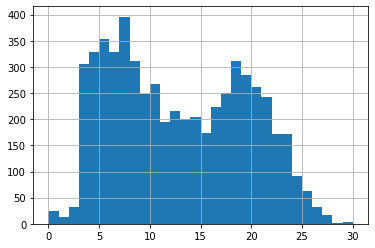

In [65]:
# Get length of all the tweets in the train set
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)

### **Set the padding length**

In [66]:
max_seq_len = 50

### **Tokenize the tweets**

In [67]:
# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_validation.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

## **Convert integer sequences to tensors**

In [68]:
# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(Y_train.tolist())

# For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(Y_validation.tolist())

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(Y_test.tolist())

## **Create Data Loaders**

In [69]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define a batch size
batch_size = 32

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# Sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, 
                              batch_size=batch_size)

# Wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# Sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# DataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, 
                            batch_size=batch_size)

## **Freeze BERT parameters**

In [70]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## **Define model architecture**

In [72]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # Dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # Relu activation function
      self.relu =  nn.ReLU()

      # Dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # Dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      # Softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):

      # Pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # Output layer
      x = self.fc2(x)
      
      # Apply softmax activation
      x = self.softmax(x)

      return x

## **Set BERT model**

In [73]:
# Pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# Push the model to GPU
model = model.to(device)

## **Define the optimizer**

In [74]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-3)

## **Find class weights**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_wts = compute_class_weight('balanced', np.unique(Y_train), Y_train)

# Convert class weights to tensor
weights= torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

# Loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# Number of training epochs
epochs = 10

## **Fine-tune BERT**

### **Training the model**

In [77]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  
  # Empty list to save model predictions
  total_preds=[]
  
  # Iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # Progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch

    # Clear previously calculated gradients 
    model.zero_grad()        

    # Get model predictions for the current batch
    preds = model(sent_id, mask)

    # Compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # Add on to the total loss
    total_loss = total_loss + loss.item()

    # Backward pass to calculate the gradients
    loss.backward()

    # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters
    optimizer.step()

    # Model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # Sppend the model predictions
    total_preds.append(preds)

  # Compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # Predictions are in the form of (no. of batches, size of batch, no. of classes).
  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  # Returns the loss and predictions
  return avg_loss, total_preds

### **Evaluating the model**

In [78]:
def evaluate():
  print("\nEvaluating...")
  
  # Deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0, 0
  
  # Empty list to save the model predictions
  total_preds = []

  # Iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # Push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    # Deactivate autograd
    with torch.no_grad():
      
      # Model predictions
      preds = model(sent_id, mask)

      # Compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # Compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## **Start model training**

In [79]:
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    179.
  Batch   100  of    179.
  Batch   150  of    179.

Evaluating...

Training Loss: 0.594
Validation Loss: 0.599

 Epoch 2 / 10
  Batch    50  of    179.
  Batch   100  of    179.
  Batch   150  of    179.

Evaluating...

Training Loss: 0.529
Validation Loss: 0.631

 Epoch 3 / 10
  Batch    50  of    179.
  Batch   100  of    179.
  Batch   150  of    179.

Evaluating...

Training Loss: 0.527
Validation Loss: 0.498

 Epoch 4 / 10
  Batch    50  of    179.
  Batch   100  of    179.
  Batch   150  of    179.

Evaluating...

Training Loss: 0.517
Validation Loss: 0.503

 Epoch 5 / 10
  Batch    50  of    179.
  Batch   100  of    179.
  Batch   150  of    179.

Evaluating...

Training Loss: 0.527
Validation Loss: 0.450

 Epoch 6 / 10
  Batch    50  of    179.
  Batch   100  of    179.
  Batch   150  of    179.

Evaluating...

Training Loss: 0.516
Validation Loss: 0.504

 Epoch 7 / 10
  Batch    50  of    179.
  Batch   100  of    179.
  Batch   150  

## **Load saved model**

In [ ]:
# Load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

## **Get predictions for test data**

In [81]:
with torch.no_grad():
  Y_pred = model(test_seq.to(device), test_mask.to(device))
  Y_pred = preds.detach().cpu().numpy()

## **Evaluate model performance**

In [82]:
Y_pred = np.argmax(Y_pred, axis = 1)

# Calculate test accuracy
print("\nTest Accuracy: ", accuracy_score(test_y, Y_pred))
print("Test Precision: ", precision_score(test_y, Y_pred))
print("Test Recall: ", recall_score(test_y, Y_pred))
print("Test F-measure: ", f1_score(test_y, Y_pred))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75       273
           1       0.87      0.79      0.83       443

    accuracy                           0.79       716
   macro avg       0.78      0.80      0.79       716
weighted avg       0.80      0.79      0.80       716



In [83]:
# Calculate test accuracy
print("\nTest Accuracy: ", accuracy_score(test_y, Y_pred))
print("Test Precision: ", precision_score(test_y, Y_pred))
print("Test Recall: ", recall_score(test_y, Y_pred))
print("Test F-measure: ", f1_score(test_y, Y_pred))


Test Accuracy:  0.7932960893854749
Test Precision:  0.8660049627791563
Test Recall:  0.7878103837471784
Test F-measure:  0.8250591016548464
